# 金融建模 #40 | 在Python中用蒙特卡洛模拟法计算VaR

## 导入各种库（Library）

In [210]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf              #通过雅虎财经导入金融数据
import matplotlib.pylab as plt   
from scipy.stats import norm       #导入的一个用于处理连续随机正太分布的模块
import math                        #用于进行指数运算
import seaborn as sns

## 设定特定的时间范围

In [211]:
#创建时间范围
years = 3
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

## 创建证券的Ticker（代码），以便从Yahoo Finance中提取财经数据

In [212]:
# SPY: SPDR S&P 500 ETF Trust标普500
# LQD: iShares iBoxx $ Investment Grade Corporate Bond ETF
# GLD: SPDR Gold Trust
# DBC: Invesco DB Commodity Index Tracking Fund 
# FXE: Invesco CurrencyShares Euro Trust

In [213]:
tickers = ['SPY','LQD','GLD','DBC','FXE']

## 从雅虎财经中将证券过去的历史收盘价格下载下来

In [214]:
#创建closePrices_df的dataframe
#通过for循环从yahoo finance中下载数据

closePrices_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker,start=startDate,end=endDate)
    closePrices_df[ticker]=data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 计算上述资产过去两年每日Log Return，并将NA的数据去除

In [215]:
#通过np.log，以及df.shift的组合计算资产的log return
logReturn = np.log(closePrices_df/closePrices_df.shift(1)).dropna()

In [216]:
logReturn

,SPY,LQD,GLD,DBC,FXE
Date,,,,,
2020-09-16,-0.003977,0.000663,0.002831,0.018321,-0.003952
2020-09-17,-0.008834,0.000220,-0.005505,0.011283,0.003952
2020-09-18,-0.011579,-0.001840,0.001311,0.004478,0.000000
2020-09-21,-0.011192,-0.000958,-0.020292,-0.024879,-0.007106
2020-09-22,0.010133,0.000590,-0.004858,-0.004591,-0.004705
...,...,...,...,...,...
2023-09-08,0.001505,0.000764,0.000337,0.001997,0.000810
2023-09-11,0.006555,-0.001912,0.001851,0.005968,0.004545
2023-09-12,-0.005501,-0.000287,-0.005170,0.003564,-0.001816


## 创建组合指标计算公式

In [217]:
#创建计算组合期望收益率的公式
def portfolio_expected_return(weights,logReturn):
    return np.sum(weights * logReturn.mean())

In [218]:
#创建计算组合标准差的公式
#如果是python 3.5版本以上的，可以使用@来计算矩阵相乘
def portfolio_standard_deviation(weights,cov_matrix):
    portfolio_variance = weights.T @ cov_matrix @ weights
    std = np.sqrt(portfolio_variance)
    return std

## 创建组合（设置组合权重）

In [219]:
#设置Portfolio初始金额
portfolio = 1000000

In [220]:
#创建一个Dictionary，将每个资产的权重都设置成一致
value_per_ticker = 1 / len(tickers)
portfolio_weights = pd.Series({ticker: value_per_ticker for ticker in tickers})

In [221]:
#portfolio_weights = {'SPY': 0.4,'LQD': 0.1,'GLD': 0.1,'DBC': 0.3,'FXE': 0.1}

In [222]:
#portfolio_weights = pd.Series(portfolio_weights)

In [223]:
#计算各个资产log收益率之间的协方差矩阵
portfolio_coveriance = logReturn.cov()

In [224]:
portfolio_coveriance

,SPY,LQD,GLD,DBC,FXE
SPY,0.000128,0.000025,0.000016,0.000038,0.000021
LQD,0.000025,0.000034,0.000020,0.000002,0.000009
GLD,0.000016,0.000020,0.000082,0.000039,0.000021
DBC,0.000038,0.000002,0.000039,0.000176,0.000013
FXE,0.000021,0.000009,0.000021,0.000013,0.000025


In [225]:
portfolioExpectedReturn = portfolio_expected_return(portfolio_weights,logReturn)
portfolioStd = portfolio_standard_deviation(portfolio_weights,portfolio_coveriance)

In [226]:
print(portfolioExpectedReturn)
print(portfolioStd)

0.00018177762234716042
0.005847595292211167


In [227]:
logReturn.mean()

SPY    0.000432
LQD   -0.000229
GLD   -0.000047
DBC    0.000909
FXE   -0.000156
dtype: float64

## 进行蒙特卡洛模拟设置

In [228]:
#通过正态分布创建随机数（标准分数/Z-Score）
def random_Z_Score():
    return np.random.normal(0,1)  


In [229]:
#确定计算几天（X天）的VaR
Days = 10

In [230]:
#创建一个公式，可以返回一次蒙特卡洛模拟下，组合在X天后的损益情况
def scenario_PL(PortSize, PortExpReturn, PortStvd,days):
    portfolioValue = PortSize
    for day in range(days):
        z_score = random_Z_Score()
        portfolioValue = portfolioValue * np.exp(PortExpReturn+PortStvd*z_score)
    PortPL = portfolioValue - PortSize
    return PortPL


## 进行蒙特卡洛模拟

In [231]:
## 设置模拟此时
simulationTimes = 100000

In [232]:
## 创建一个空列表来装载模拟的结果
simulationResult = []

In [233]:
## 进行模拟
for i in range(simulationTimes):
    pl =  scenario_PL(portfolio,
                      portfolioExpectedReturn,
                      portfolioStd,
                      Days
                      )
    simulationResult.append(pl)


In [ ]:
simulationResult

In [235]:
pd.DataFrame(simulationResult).describe()

,0
count,100000.000000
mean,1901.545268
std,18545.436449
min,-73551.824749
25%,-10773.830712
50%,1742.140921
75%,14386.056368
max,93576.567795


## 设置执行区间，并计算VaR值

- 置信区间水平设置越高(显著性水平越小），损失越大
- 天数（days）越大，损失越大

In [236]:
#设置confidence_interval = 0.95
confidence_interval = 0.95

In [237]:
#通过np.percentile计算VaR值
VaR = np.percentile(simulationResult,100 - confidence_interval*100)

In [238]:
print(VaR)

-28338.676826373227


## 将数据可视化呈现

<function matplotlib.pyplot.show(close=None, block=None)>

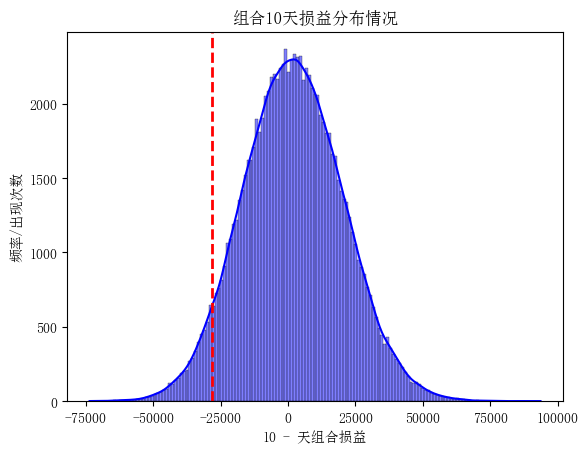

In [244]:
#进行作图
sns.histplot(simulationResult, kde=True, color='blue')
plt.xlabel(f'{Days} - 天组合损益')
plt.ylabel('频率/出现次数')
plt.title(f'组合{Days}天损益分布情况')
plt.axvline(VaR,color='r',linestyle='dashed',linewidth=2,label=f'在{confidence_interval:.0%}置信水平下的VaR')
plt.legend
plt.rcParams['font.sans-serif'] = ['SimSun']
plt.rcParams['axes.unicode_minus'] = False 
plt.show